In [6]:
import tmtoolkit
import pickle
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import random 
import numpy as np
import math
from IPython.display import clear_output

In [7]:
def cv_token_return(doc):
    return doc

wordvect = pickle.load(open("wordvect.pickel", "rb"))
dtm = pickle.load(open("dtm.pickel", "rb"))


data = pd.read_csv("../../../data/processed_data/data_full_processed.csv", sep=",")
r, c = data.shape
print(f"The data has {r} row and {c} columns")

The data has 363 row and 3 columns


In [8]:
var_params = [{'n_components': k, 'doc_topic_prior': 1/k}
            for k in range(2, 20, 2)]
var_params

[{'n_components': 2, 'doc_topic_prior': 0.5},
 {'n_components': 4, 'doc_topic_prior': 0.25},
 {'n_components': 6, 'doc_topic_prior': 0.16666666666666666},
 {'n_components': 8, 'doc_topic_prior': 0.125},
 {'n_components': 10, 'doc_topic_prior': 0.1},
 {'n_components': 12, 'doc_topic_prior': 0.08333333333333333},
 {'n_components': 14, 'doc_topic_prior': 0.07142857142857142},
 {'n_components': 16, 'doc_topic_prior': 0.0625},
 {'n_components': 18, 'doc_topic_prior': 0.05555555555555555}]

In [9]:
from tmtoolkit.topicmod import tm_sklearn
tm_sklearn.AVAILABLE_METRICS

('perplexity',
 'cao_juan_2009',
 'arun_2010',
 'coherence_mimno_2011',
 'coherence_gensim_u_mass',
 'coherence_gensim_c_v',
 'coherence_gensim_c_uci',
 'coherence_gensim_c_npmi',
 'coherence_gensim_u_mass',
 'coherence_gensim_c_v',
 'coherence_gensim_c_uci',
 'coherence_gensim_c_npmi')

In [28]:
from tmtoolkit.topicmod.tm_sklearn import evaluate_topic_models
from tmtoolkit.topicmod.evaluate import results_by_parameter

const_params = {
    'max_iter':250, # Max learning iterations
    'learning_method':'batch',   
    'random_state':20191122, # Random state
    'batch_size':128,  # n docs in each learning iter
    'evaluate_every':10, # compute perplexity every n iters, default: Don't
    'n_jobs':1,  # to make results reproducible
    'topic_word_prior': 0.1               # sometimes also called "beta"
}

eval_results = evaluate_topic_models(dtm,
                                     varying_parameters=var_params,
                                     constant_parameters=const_params,
                                     coherence_mimno_2011_top_n=10,
                                     coherence_mimno_2011_include_prob=True,
                                     return_models=True,
                                     n_max_processes=32)

eval_results[:3]  # only show first three models

import pickle
pickle.dump(eval_results, open("eval_results_100.pickel", "wb"))

In [29]:
import pickle
from tmtoolkit.topicmod.tm_sklearn import evaluate_topic_models
from tmtoolkit.topicmod.evaluate import results_by_parameter
eval_results = pickle.load(open("eval_results_100.pickel", "rb"))

In [30]:
eval_results_by_topics = results_by_parameter(eval_results, 'n_components')
eval_results_by_topics[:3]  # again only the first three models

[(2,
  {'model': LatentDirichletAllocation(doc_topic_prior=0.5, evaluate_every=10, max_iter=250,
                             n_components=2, n_jobs=1, random_state=20191122,
                             topic_word_prior=0.1),
   'perplexity': 593.5475290135793,
   'cao_juan_2009': 0.20502394471558083,
   'coherence_mimno_2011': -494.3162650172725}),
 (4,
  {'model': LatentDirichletAllocation(doc_topic_prior=0.25, evaluate_every=10, max_iter=250,
                             n_components=4, n_jobs=1, random_state=20191122,
                             topic_word_prior=0.1),
   'perplexity': 580.1005503336042,
   'cao_juan_2009': 0.2382777076054905,
   'coherence_mimno_2011': -468.92723136535244}),
 (6,
  {'model': LatentDirichletAllocation(doc_topic_prior=0.16666666666666666,
                             evaluate_every=10, max_iter=250, n_components=6,
                             n_jobs=1, random_state=20191122,
                             topic_word_prior=0.1),
   'perplexity': 555.

/Users/pierreachkar/miniconda3/envs/cer_project/lib/python3.10/site-packages/tmtoolkit/topicmod/visualize.py:833: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(**subplots_adjust_kwargs)


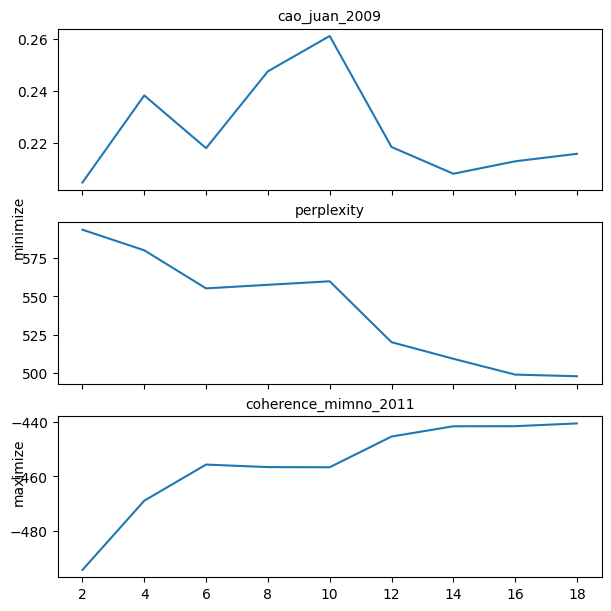

In [31]:
from tmtoolkit.topicmod.visualize import plot_eval_results
plot_eval_results(eval_results_by_topics);

In [33]:
best_tm = [m for k, m in eval_results_by_topics if k == 6][0]['model']
best_tm.n_components, best_tm.doc_topic_prior, best_tm.topic_word_prior  # just to make sure

(6, 0.16666666666666666, 0.1)

In [34]:
from tmtoolkit.topicmod.model_stats import marginal_topic_distrib
from tmtoolkit.bow.bow_stats import doc_lengths

doc_lengths_bg = doc_lengths(dtm)
marg_topic = marginal_topic_distrib(best_tm.transform(dtm), doc_lengths_bg)

In [35]:
#Saliency
from tmtoolkit.topicmod.model_stats import word_distinctiveness, \
    most_distinct_words, least_distinct_words

word_distinct = word_distinctiveness(best_tm.components_, marg_topic)
word_distinct[:10]   # first 10 words in vocab

array([0.62551896, 0.69786098, 1.95558223, 0.58150747, 1.78867721,
       0.92066184, 1.21770851, 0.46063776, 0.59761594, 0.41924681])

In [36]:
most_distinct_words(wordvect.get_feature_names_out(), best_tm.components_,
                    best_tm.transform(dtm), doc_lengths_bg,
                    n=10)

array(['scheduling', 'information', 'tools', 'building',
       'power_consumption', 'theory', 'manufacturing', 'based', 'horizon',
       'countries'], dtype=object)

In [37]:
least_distinct_words(wordvect.get_feature_names_out(), best_tm.components_,
                    best_tm.transform(dtm), doc_lengths_bg,
                    n=10)

array(['done', 'part', 'everything', 'towards', 'smart', 'analysis',
       'come', 'sensor', 'sensors', 'achieve'], dtype=object)

In [38]:
#Compare Model Reliability
import pickle
import numpy as np
from tqdm import tqdm


final = []

def set_n_to_zero(x, n):
    indexes = np.argpartition(x,-n)[-n:]
    mask = np.ones(x.size, dtype=bool)
    mask[indexes] = False
    x[mask] = 0
    return x

for i in tqdm(range(10)):
    lda_model = pickle.load(open(f'lda_model_{i}.pkl', "rb"))
    lda_output = pickle.load(open(f'lda_output_{i}.pkl', "rb"))
    final.append(np.apply_along_axis(set_n_to_zero, 1, lda_model.components_, n=40))
        

#make comparison
final = np.asarray(final)
final.shape

100%|██████████| 10/10 [00:00<00:00, 206.25it/s]


(10, 6, 641)

In [39]:
lda_model.components_

array([[ 0.        , 28.06828965,  6.30351906, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , 31.62838094, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [33.98410588,  9.27129908,  8.56770406, ...,  0.        ,
         0.        ,  0.        ],
       [15.34772407,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [40]:
final[1,:,:].shape[0]

6

In [41]:
from scipy.spatial import distance

compare = np.zeros((final[1,:,:].shape[0], final[1,:,:].shape[0]))

all_models_reli = []
min_sim = 0.7
    
for k in range(10):
    for l in range(10):
        if(k!=l):
            for i in range(final[k,:,:].shape[0]):
                for j in range(final[l,:,:].shape[0]):
                    compare[i,j] = (1 - distance.cosine(final[k,i,:],final[l,j,:]))

            stopped = False
            total_overlap = 0


            while(stopped != True):
                index = np.unravel_index(compare.argmax(), compare.shape)
                #print(index)
                total_overlap += 1
                if(compare[index] < min_sim):
                    stopped = True
                compare[index] = 0
                compare[index[1],index[0]] = 0

            all_models_reli.append(total_overlap/final[1,:,:].shape[0])

np.asarray(all_models_reli).mean()

0.16666666666666666

In [24]:
correct_selections = 0
K = best_tm.components_.shape[0]
runs = 10
topic = "random"
setsize = 5
chance_correction = False

for iter in range(runs):
    print(f'Word intrusion {iter} of runs\n')
    # select a topic
    if (topic == "random"):
      k = random.randint(0, K)
    else:
      k <- topic

    # select setsize - 1 most probable words
    top_words = np.argsort(best_tm.components_[k-1,:])[::-1]
    top_words_setsize = wordvect.get_feature_names_out()[top_words[:setsize]]
    
    
    
    # select intruder word with low probability from current topic, but high probability in some other topic
    V = best_tm.components_.shape[1]
    top30 = min(V, 30)
    
    high_prob_terms = []
    
    for i in range(K):
        if(i != k):
            top_words_i = np.argsort(best_tm.components_[i,:])[::-1]
            top_words_setsize_i = wordvect.get_feature_names_out()[top_words_i[:top30]]
            high_prob_terms.append(top_words_setsize_i)
    
    high_prob_terms = set(np.unique(np.asarray(high_prob_terms).flatten()))
    low_prob_terms = set(wordvect.get_feature_names_out()[top_words[math.ceil(0.25 * V):V]])
    selection_terms = high_prob_terms & low_prob_terms

    intruder = random.choices(list(selection_terms), k=1)
    
    eval_list = np.insert(
        top_words_setsize,
        random.randint(0, len(top_words_setsize)), 
        intruder)
    intruder_true_position = np.where(eval_list == intruder)[0]

    for j in range(setsize): 
        print(f"[{j}]{eval_list[j]}\n")
    
    intruder_user_selection = int(input("Enter your input: "))
    #clear_output(wait=True)
    
    if (intruder_true_position == intruder_user_selection):
        print("CORRECT SELECTION\n")
        correct_selections +=  1
    else:
        print("FALSE SELECTION\n")
        
    
        
performance = correct_selections / runs

if(chance_correction):
    random_probabilty = 1 / setsize
    performance = (performance - random_probabilty) / (1 - random_probabilty)
  
print(f"Performance: {performance} ({correct_selections} out of {runs} runs)\n")
    #print(top_words_setsize)
    #print(intruder)

Word intrusion 0 of runs

[0]process

[1]transportation

[2]internet_things

[3]time

[4]evs



KeyboardInterrupt: Interrupted by user

In [25]:
# Show top n keywords for each topic
def show_topics(vectorizer, lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names_out())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=wordvect, lda_model=best_tm, n_words=15)# Topic - Keywords Dataframe

df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]

#Time series
topic_labels = []

for index, row in df_topic_keywords.iterrows():
    topic_labels.append('.'.join(row[0:5].to_list()))

print(topic_labels)

['life.value.performance.image.datasets', 'building.strategy.buildings.mec.tasks', 'networks.communication.materials.methods.based', 'resource.tools.using.challenges.health', 'models.using.software.cities.research', 'detection.home.wind.sources.monitoring', 'cities.city.environment.information.strategies', 'scheduling.optimization.model.based.plant', 'distribution.technologies.process.grid.improve', 'challenges.internet.demand.approach.grid', 'techniques.panels.buildings.demand.framework', 'manufacturing.electricity.carbon.equipment.resources', 'machine.model.wind.waste.used', 'process.transportation.internet_things.evs.wireless']


In [27]:
# Topic instrusion
# Topic instrusion
theta = best_tm.transform(dtm)
correct_selections = 0
K = best_tm.components_.shape[0]
runs = 10
n_docs = theta.shape[0]
chance_correction = False
docs = random.sample(range(n_docs), runs)
setsize = 3
for iter in range(runs):
    d = docs[iter]

    print(f"Topic intrusion {iter} of {runs}\n")
    
    doc_text = data.abstract[d]
    
    # select setsize - 1 most probable topic
    top_topics = np.argsort(theta[d,:])[::-1]
    top_topic_names = [label for idx, label in enumerate(topic_labels) if idx in top_topics[:(setsize-1)]]
    intruder_topic = random.choices(list(top_topics[math.ceil((K+1)/2):K-1]), k=1)
    intruder_topic_name = topic_labels[intruder_topic[0]]
    
    eval_list = np.insert(
        top_topic_names,
        random.randint(0, len(top_topic_names)), 
        intruder_topic_name)
    
    intruder_true_position = np.where(eval_list == intruder_topic_name)[0]
    
    print(f'{doc_text}\n')
    
    for i in range(setsize): 
        print(f"[{i}] {eval_list[i]}\n")

    intruder_user_selection = int(input("Enter your input: "))
    clear_output(wait=True)
    
    if (intruder_true_position == intruder_user_selection):
        print("CORRECT SELECTION\n")
        correct_selections +=  1
    else:
        print("FALSE SELECTION\n")
    
performance = correct_selections / runs

if(chance_correction):
    random_probabilty = 1 / setsize
    performance = (performance - random_probabilty) / (1 - random_probabilty)
  
print(f"Performance: {performance} ({correct_selections} out of {runs} runs)\n")
    #print(top_words_setsize)
    #print(intruder)

Topic intrusion 0 of 10

Power systems are evolving rapidly with the integration and active use of emerging digitalization technologies, including but not limited to Artificial Intelligence, Blockchain / Distributed Ledger Technology (B/DLT), and other Information and Communication Technologies. Besides the active integration of digitalization technologies into modern power systems, decarbonization efforts are also shaping the energy transition process to be further demystified under the Digital Green Shift convention in a joint manner. B/DLT appears to be one of the most promising enabling technologies to realize the full energy transition toward next-generation power markets and systems. Standardization of such technologies is playing a critical role in the rapid adoption of emerging technologies. This article aims to reflect the industrial and academic perspectives of practical approaches of B/DLT in the Energy Domain and the potential contributions of the proposed scope in terms of

ValueError: invalid literal for int() with base 10: ''

In [ ]:
tm_topic_intrusion <- function(beta, theta, corpus, runs = 10, setsize = 4, document = "random", chance_correction = T) {

  for (iter in 1:runs) {

    


    eval_list <- sample(c(top_topic_names, intruder_topic_name))
    intruder_true_position <- which(eval_list == intruder_topic_name)

    for (i in 1:setsize) cat("[", i, "] ", eval_list[i], "\n")

    intruder_user_selection <- readIntruder()

    if (intruder_true_position == intruder_user_selection) {
      cat("CORRECT SELECTION\n")
      correct_selections <- correct_selections + 1
    } else {
      cat("FALSE SELECTION\n")
    }

  }

  performance <- correct_selections / runs

  if (chance_correction) {
    random_probabilty <- 1 / setsize
    performance <- (performance - random_probabilty) / (1 - random_probabilty)
  }

  cat("Performance:", performance, " (", correct_selections, " out of ", runs, ")\n")

  return(performance)
}